In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,6)



# THE GRAPH CONTROL PANEL

In [2]:
N = 50          # Number of nodes
setting='home'    #the setting we are evaluating(home,work,school,other)
D=300             #number of days the model runs
threshold=.004    #the threshold of a contact to happen
increase_rate=.008 #the rate of increasing weight per contact
decrease_rate=.008 #the rate of decreasing weight if no contact
base_weight=.005    #the presumed weight for initial graph
lower_weight=.001  #the minimum weight between two node(Max is =1)
threshold_n=.00005     #threshold of product weight two nodes with same neighbor for increasing weight
increse_rate_n=.008   #increse rate weight for two nodes with same neighbor

## 1-Defining Nodes

In [3]:
G = nx.Graph()

In [4]:
#defining a dictionary of nodes
available_groups  = [] #16_age_groups
group_popularity = [] #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict()

with open ('population.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        available_groups.append(row[0])
        group_popularity.append(float(row[1]))
        
with open ('varicella_prevalance.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        v_prevalence[row[0]]=[float(row[1]),float(row[2])]
        
        


for i in range(N):
    while True:
        r=random.random()
        t=random.randint(0,15)
        if r<=group_popularity[t]:
            nodes_dic[f'n{i+1}']={'age':available_groups[t]}
            break


for i in range(N):
    a=v_prevalence[nodes_dic[f'n{i+1}']['age']][0]
    b=v_prevalence[nodes_dic[f'n{i+1}']['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[f'n{i+1}']['infection']=1
    else:
        nodes_dic[f'n{i+1}']['infection']=0
        

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [5]:

# let's see the number of nodes in each group:

group_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in group_count:
        group_count[nodes_dic[n]['age']] = group_count[nodes_dic[n]['age']] + 1
    else:
        group_count[nodes_dic[n]['age']] = 1
group_count

{'15_19': 5,
 '25_29': 3,
 '0_4': 5,
 '20_24': 5,
 '30_34': 7,
 '40_44': 4,
 '75+': 6,
 '5_9': 2,
 '45_49': 3,
 '10_14': 5,
 '65_69': 1,
 '55_59': 1,
 '35_39': 3}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [6]:
#importing rules from .csv to nested dictionary
rules={}  # rules contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]


with open ('contact_rules.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        
        location.append(row[0])
        contactor.append(row[1])
        contactee.append(row[2])
        contact_number.append(float(row[3]))


for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules[location[o]]=temp_1.copy()     

In [7]:
#building a graph with all weights presumed to be .2
#bulding empty dictinary "contacted" for storing contacts in single rrun
#building empty dictionary for monitoring all contacts during all runs
contacted={}
contacted_all={}
for i in nodes_dic.keys():
    contacted[i]={}
    contacted_all[i]={}
    for j in nodes_dic.keys():
        if i!=j:
            G.add_edge(i,j,weight=base_weight)
            contacted[i][j]=0 
            contacted_all[i][j]=[]


## 3- Visualization for `SMALL` graph

### ⚠️ Only for SMALL graphs (i.e. noes < 100)

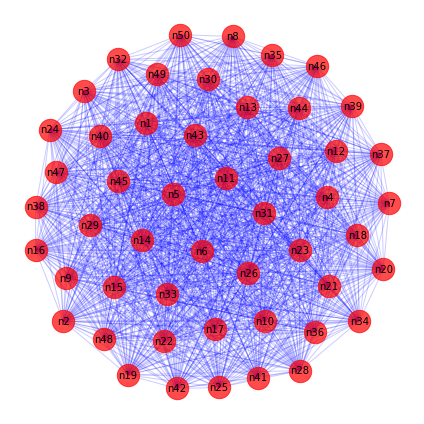

In [8]:
pos = nx.spring_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red', alpha=0.7)

# edges
nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, edge_color="b", style="-")

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## 4-Defining Rules to Connecting Nodes and Adjusting `Probabilities/Distances`

* This would be the step that our Naive graph would evolve over the time through a simulation process
* we monitor connection between nodes and update weights based on connections

In [9]:

for d in range (0,D):#we are running the model for 100 days
    #iterating thorough the graph and storing connections in 'contacted'
    
    for i in nodes_dic.keys():
        for j in nodes_dic.keys():
            if i!=j:
                 #age_p is the number of contact between nodes by age
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]["age"]]
                r=random.random()
                if G[i][j]['weight']*r*age_p > threshold:
                    contacted[i][j]=1
                    contacted_all[i][j].append(1)#storing contacts of each run in this dic
                else:
                    contacted_all[i][j].append(0)
    #iterating thorough 'contacted' and updating the weights based on it
    for i in nodes_dic.keys():
        for j in nodes_dic.keys():
            if i!=j:
                if contacted[i][j]==1 and G[i][j]['weight']<1 :
                    #we don't want the weight to be 1 or more
                    t=G[i][j]['weight']+increase_rate
                    G.add_edge(i,j,weight=t)
                    
                elif contacted[i][j]==0 and G[i][j]['weight']>lower_weight : 
                    #we don't want the weight to be 0 or less
                    t=G[i][j]['weight']-decrease_rate
                    G.add_edge(i,j,weight=t)
                    
    #updating weight between two nodes with same neighbor
    for i in nodes_dic.keys():
        for j in nodes_dic.keys():
            if i!=j:
                for o in nodes_dic.keys():
                    if o!=j and o!=i:
                        
                        if (G[i][o]['weight']*G[i][j]['weight'])>threshold_n and G[o][j]['weight']<1:
                            t=G[o][j]['weight']+increse_rate_n
                            G.add_edge(i,j,weight=t)
                            
                            

### Visualize the graph after the updates

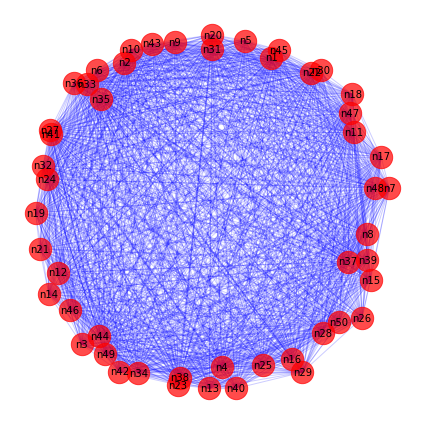

In [10]:
pos = nx.spring_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red', alpha=0.7)

# edges
nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, edge_color="b", style="-")

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# 5- Monitroing the graph
### we monitor the graph for age specific number of contact per day and frequeny of contact

In [11]:
#this part returns the ages specified number of conatacts as rules_mirror


rules_mirror=dict()
rules_mirror[setting]=dict()


for i in rules[setting].keys():
    rules_mirror[setting][i]=dict()
    for j in rules[setting][i].keys():
         rules_mirror[setting][i][j]=0

            
for i in nodes_dic.keys():
    for j in nodes_dic.keys():
        if i!=j:
            t=sum(contacted_all[i][j])/D
            rules_mirror[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t

for i in rules_mirror[setting].keys():
    for j in rules_mirror[setting][i].keys():
        print(i,j,'model:',rules_mirror[setting][i][j],'original:',rules[setting][i][j])



0_4 0_4 model: 0.0 original: 0.43913
0_4 5_9 model: 0.0 original: 0.70013
0_4 10_14 model: 0.0 original: 0.45382
0_4 15_19 model: 0.0 original: 0.25108
0_4 20_24 model: 0.0 original: 0.41814
0_4 25_29 model: 0.0 original: 0.58958
0_4 30_34 model: 0.0 original: 0.56166
0_4 35_39 model: 0.0 original: 0.44455
0_4 40_44 model: 0.0 original: 0.24272
0_4 45_49 model: 0.0 original: 0.12269
0_4 50_54 model: 0 original: 0.1481
0_4 55_59 model: 0.0 original: 0.13615
0_4 60_64 model: 0 original: 0.08664
0_4 65_69 model: 0.0 original: 0.04243
0_4 70_74 model: 0 original: 0.01513
0_4 75+ model: 0.0 original: 0.01275
10_14 0_4 model: 0.0 original: 0.29022
10_14 5_9 model: 0.0 original: 0.58282
10_14 10_14 model: 0.0 original: 0.79402
10_14 15_19 model: 0.0 original: 0.4293
10_14 20_24 model: 0.0 original: 0.12883
10_14 25_29 model: 0.0 original: 0.11601
10_14 30_34 model: 0.0 original: 0.23366
10_14 35_39 model: 0.0 original: 0.36032
10_14 40_44 model: 0.0 original: 0.34993
10_14 45_49 model: 0.0 or

In [12]:
#this part returns the frequency of contacts 
n=0
frequency={1:0,2:0,3:0,4:0,5:0}
for i in nodes_dic.keys():
    for j in nodes_dic.keys():
        if i!=j:
            t=sum(contacted_all[i][j])/D
            
            if t==1/D:
                frequency[5]+=1
                n+=1
            elif t>1/D and t<(1/30) :
                frequency[4]+=1
                n+=1
            elif t>=(1/30) and t<=(2/30):
                frequency[3]+=1
                n+=1
            elif t>(2/30) and t <=(2/7):
                frequency[2]+=1
                n+=1
            elif t>=(2/7):
                n+=1
                frequency[1]+=1

for i in frequency.keys():
    frequency[i]=frequency[i]/n
                
                
print('for the first time:',frequency[5],'\nless than once a month:',frequency[4],'\nabout once or twice a month:',frequency[3],'\nabout once or twice a week',frequency[2],'\ndaily or almost daily',frequency[1])
        
                
                

for the first time: 0.0 
less than once a month: 0.125 
about once or twice a month: 0.0 
about once or twice a week 0.6875 
daily or almost daily 0.1875
